# Milestone 01
# Peter Lorenz

## 0. Preliminaries

Import the required libraries:

In [57]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Set global options:

In [155]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do not truncate numpy arrays
np.set_printoptions(threshold=sys.maxsize)

Declare utility functions:

In [154]:
# Display kernel density plot for the given column with options
def show_kde_plot(df, col, axis):
    # Compute rough bandwidth "factor" from range
    bandwidth = np.ptp(df[col]) / 50

    # Display plot and labels
    sns.kdeplot(df.loc[:, col], ax = axis, bw = bandwidth)
    axis.set_xlabel(col) # Set text for the x axis
    axis.set_ylabel('Density')# Set text for y axis

## 1. Refine data understanding / Prepare DFD of solving the manufacturing quality problem
In this section we refine our understanding of the data and prepare a dataflow diagram that describes a potential solution to the manufacturing quality problem.

## 2. Read and merge data
First we import the sensor data set and its accompanying labels, generating column names as necessary for convenient reference to specific features:

In [310]:
# Internet location of the data set and labels
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# Download sensor data and labels into a dataframe object, specify python engine for regex
sensor_data = pd.read_csv(url, sep='\s{1,}', engine='python')
sensor_labels_data = pd.read_csv(labels_url, sep='\s{1,}', engine='python')

# Generate index-based column names for the sensor data set
sensor_data.columns = list('s' + str(idx + 1) for idx in range(0, sensor_data.shape[1]))

# Assign column names to the labels
sensor_labels_data.columns = ['result', 'date', 'time']

# Save the original data frame for future reference as we modify its contents
sensor_data_orig = sensor_data

# Display shape and initial values of the sensor data set
print('Sensor data set:')
sensor_data.shape
sensor_data.head()

# Display shape and data for labels
print('Sensor labels:')
sensor_labels_data.shape
sensor_labels_data.head()

Sensor data set:


(1566, 590)

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
0,3095.780,2465.140,2230.422,1463.661,0.829,100.000,102.343,0.125,1.497,-0.001,...,0.006,208.204,0.502,0.022,0.005,4.445,0.010,0.020,0.006,208.204
1,2932.610,2559.940,2186.411,1698.017,1.510,100.000,95.488,0.124,1.444,0.004,...,0.015,82.860,0.496,0.016,0.004,3.175,0.058,0.048,0.015,82.860
2,2988.720,2479.900,2199.033,909.793,1.320,100.000,104.237,0.122,1.488,-0.012,...,0.004,73.843,0.499,0.010,0.003,2.054,0.020,0.015,0.004,73.843
3,3032.240,2502.870,2233.367,1326.520,1.533,100.000,100.397,0.123,1.503,-0.003,...,nan,nan,0.480,0.477,0.104,99.303,0.020,0.015,0.004,73.843
4,2946.250,2432.840,2233.367,1326.520,1.533,100.000,100.397,0.123,1.529,0.017,...,0.005,44.008,0.495,0.019,0.004,3.828,0.034,0.015,0.005,44.008


Sensor labels:


(1566, 3)

,result,date,time
0,-1,"""19/07/2008","12:32:00"""
1,1,"""19/07/2008","13:17:00"""
2,-1,"""19/07/2008","14:43:00"""
3,-1,"""19/07/2008","15:22:00"""
4,-1,"""19/07/2008","17:53:00"""


## 3. Clean and prepare data
We begin by examining the data types:

In [196]:
# List columns with data types
sensor_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 590 columns):
 #   Column  Dtype  
---  ------  -----  
 0   s1      float64
 1   s2      float64
 2   s3      float64
 3   s4      float64
 4   s5      float64
 5   s6      float64
 6   s7      float64
 7   s8      float64
 8   s9      float64
 9   s10     float64
 10  s11     float64
 11  s12     float64
 12  s13     float64
 13  s14     float64
 14  s15     float64
 15  s16     float64
 16  s17     float64
 17  s18     float64
 18  s19     float64
 19  s20     float64
 20  s21     float64
 21  s22     float64
 22  s23     float64
 23  s24     float64
 24  s25     float64
 25  s26     float64
 26  s27     float64
 27  s28     float64
 28  s29     float64
 29  s30     float64
 30  s31     float64
 31  s32     float64
 32  s33     float64
 33  s34     float64
 34  s35     float64
 35  s36     float64
 36  s37     float64
 37  s38     float64
 38  s39     float64
 39  s40     float64
 40  s41  

All of the columns are float64, so there are no categorical columns to one-hot encode and no casting is needed. Now we look for missing data by finding the number of columns containing at least one NaN:

In [311]:
# Display number of columns with NaN in sensor data set
print("Number of columns with NaN:", len(sensor_data.columns[sensor_data.isna().any()]))

Number of columns with NaN: 534



Most columns have at least one NaN. What we must decide is at what point to drop a column because it has too much missing data, balancing the cost of dropping columns against the cost of having columns with a significant proportion of imputed values. For a sense of the extent of the problem, we count the number of columns with greater than 5% and 10% NaN's respectively:

In [312]:
# Count NaN's per column
df_na = sensor_data.isna().sum()

# Identify and display columns above various cutoff percentages of NaN's
df_1_pct = df_na[df_na > 0.01 * sensor_data.shape[0]]
df_3_pct = df_na[df_na > 0.03 * sensor_data.shape[0]]
df_5_pct = df_na[df_na > 0.05 * sensor_data.shape[0]]
df_10_pct = df_na[df_na > 0.1 * sensor_data.shape[0]]
df_20_pct = df_na[df_na > 0.2 * sensor_data.shape[0]]

print(df_1_pct.shape[0], 'columns are more than 1% NaN')
print(df_3_pct.shape[0], 'columns are more than 3% NaN')
print(df_5_pct.shape[0], 'columns are more than 5% NaN')
print(df_10_pct.shape[0], 'columns are more than 10% NaN')
print(df_20_pct.shape[0], 'columns are more than 20% NaN')

103 columns are more than 1% NaN
60 columns are more than 3% NaN
52 columns are more than 5% NaN
52 columns are more than 10% NaN
32 columns are more than 20% NaN


There seems to be a space between 3% and 20% that separates columns with a manageable proportion of NaN's and columns where imputing NaN's might be expected to impact the results. So we drop the 52 columns 6% or more of whose values are NaN:

In [313]:
# Drop columns with more than 5% NaN's
sensor_data = sensor_data.drop(list(df_5_pct.index), axis=1)
sensor_data.shape

(1566, 538)

We can see that 52 columns were dropped, leaving 538 columns in the dataframe:

In [314]:
# Display status after dropping zero-variance columns
print('Columns retained in data frame:', len(sensor_data.columns))
print('Number of columns dropped:', len(sensor_data_orig.columns) - len(sensor_data.columns))

Columns retained in data frame: 538
Number of columns dropped: 52


We now impute missing values in the remaining columns using the median value of the column:

In [315]:
# Impute and replace missing values using column median
sensor_data = sensor_data.replace('?', np.NaN).apply(lambda x: x.fillna(x.median()))

# Verify imputation of missing values
print("Number of columns with NaN:", len(sensor_data.columns[sensor_data.isna().any()]))

Number of columns with NaN: 0


Our data set is now free of missing values. We also verify that the labels data is free of missing values by displaying the number of columns with missing values:

In [23]:
# Display number of columns with NaN in sensor labels
print("Number of columns with NaN:", 
      len(sensor_labels_data.columns[sensor_labels_data.isna().any()]))

Number of columns with NaN: 0


Since neither the main data set nor the labels is left with missing values, we can now proceed to data exploration.

## 4. Explore data visually
Next we explore the data visually to gain insight into how to approach creating a model. With so many features (590), the challenge of course is to display potential issues in the data and promising relationships between variables in a way that does not overwhelm the viewer.

We begin by examining the distributions of the variables.

But before we can compute these distributions, we have to deal with features whose variance is zero. This problem became apparent when seaborn's kdeplot function produced the following warning: "Data must have variance to compute a kernel density estimate." This issue arises from the need to scale the data to compute and render the distribution.

So a preliminary step in our exploration of the data is to perform additional cleaning of the data by dropping columns with zero variance. Many of these columns are simply all zero, though some have other constant values (e.g. s6 == 100). To address this, we drop all columns whose variance is zero:

In [126]:
# Display columns with zero variance
np.array(sensor_data.columns[sensor_data.var() == 0])

# Drop columns with zero variance
sensor_data = sensor_data.drop(sensor_data.columns[sensor_data.var() == 0], axis=1)

array(['s6', 's14', 's43', 's50', 's53', 's70', 's98', 's142', 's150',
       's179', 's180', 's187', 's190', 's191', 's192', 's193', 's194',
       's195', 's227', 's230', 's231', 's232', 's233', 's234', 's235',
       's236', 's237', 's238', 's241', 's242', 's243', 's244', 's257',
       's258', 's259', 's260', 's261', 's262', 's263', 's264', 's265',
       's266', 's267', 's277', 's285', 's314', 's315', 's316', 's323',
       's326', 's327', 's328', 's329', 's330', 's331', 's365', 's370',
       's371', 's372', 's373', 's374', 's375', 's376', 's379', 's380',
       's381', 's382', 's395', 's396', 's397', 's398', 's399', 's400',
       's401', 's402', 's403', 's404', 's405', 's415', 's423', 's450',
       's451', 's452', 's459', 's462', 's463', 's464', 's465', 's466',
       's467', 's482', 's499', 's502', 's503', 's504', 's505', 's506',
       's507', 's508', 's509', 's510', 's513', 's514', 's515', 's516',
       's529', 's530', 's531', 's532', 's533', 's534', 's535', 's536',
      

We can see that 116 columns were dropped, leaving 474 columns in the dataframe:

In [128]:
# Display status after dropping zero-variance columns
print('Columns retained in data frame:', len(sensor_data.columns))
print('Number of columns dropped:', len(sensor_data_orig.columns) - len(sensor_data.columns))

Columns retained in data frame: 474
Number of columns dropped: 116


In [173]:
# Display columns with less than ten values
for x in sensor_data.columns:
    num_vals = len(np.unique(sensor_data[x]))
    if num_vals < 10:
        print('Column', x, 'has', num_vals, 'values')

Column s75 has 2 values
Column s207 has 2 values
Column s210 has 2 values
Column s343 has 2 values
Column s348 has 2 values
Column s479 has 2 values
Column s522 has 9 values


In [193]:
# Zeroes per column
#sensor_data.columns[sensor_data[sensor_data == 0].count(axis=0) > 0]
df = sensor_data[sensor_data == 0].count(axis=0)
with pd.option_context('display.max_rows', 1566, 'display.max_columns', None):
    df[df > 1]
#list(zip(sensor_data.columns[sensor_data[sensor_data == 0].count(axis=0) > 0],
#        sensor_data[sensor_data == 0].count(axis=0) > 0))

s8         8
s10        5
s11        7
s75     1565
s76        3
s78        5
s80        2
s81        2
s82        2
s83        3
s92       64
s93       27
s94       35
s95      498
s96      683
s97       59
s99       64
s100      73
s101     291
s102     462
s103      59
s105     115
s106      87
s107      89
s108      65
s109      59
s113       9
s115    1544
s129       5
s130     177
s144       8
s163       5
s207    1565
s210    1565
s248      10
s250    1544
s279       8
s298       5
s343    1565
s348    1565
s368      58
s369      58
s386      10
s388    1544
s417       8
s419     512
s420     711
s433      57
s434     187
s469     244
s479    1565
s483     482
s484     138
s485     216
s486     184
s487     504
s488     343
s489     229
s490     195
s500     853
s501     910
s511       2
s512     821
s520      10
s522    1545
s582       8
s590      32
dtype: int64

Now we perform kernel density analysis on the remaining columns:

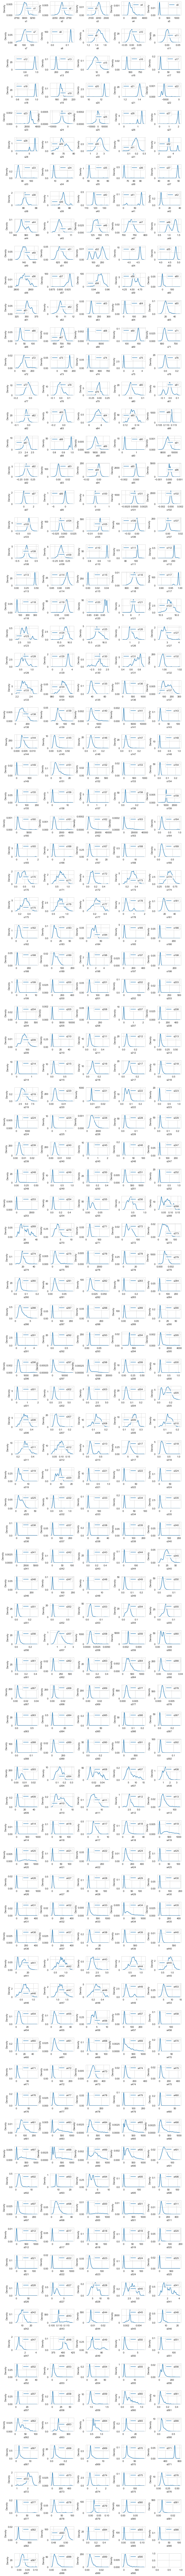

In [156]:
# Display kernel density plot for each feature
# Basically, this code divides up a subplot area based on the number of columns
# then assigns one plot to each area to fit all plots in a reasonable area
df_cols = len(sensor_data.columns)
COLS = 5
ROWS = int((df_cols - 1) / 5 + 1)
FIRST_COL = 1
LAST_COL = COLS * ROWS
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(12, ROWS * 2))
plt.subplots_adjust(wspace=0.5, hspace=1)

cur_col = 0
for i in range(FIRST_COL, LAST_COL + 1):
    if cur_col == len(sensor_data.columns):
        break
    row = int((i - 1) / COLS)
    col = (i - 1) % COLS
    col_name = sensor_data.columns[[cur_col]][0]
    cur_col = cur_col + 1
    try:
        show_kde_plot(sensor_data, col_name, axes[row][col])
    except Exception as e:
        print('Col ', col_name, ' error, col type = ', sensor_data[col_name].values.dtype)
        print('Range of column is ', str(np.ptp(sensor_data[col_name])))
        print('Standard deviation is ', str(np.std(sensor_data[col_name])))
        print('Variance is ', str(np.var(sensor_data[col_name])))
        print(e)

Next we look at the relationships between the columns, starting with the correlation matrix:

In [44]:
corr = sensor_data.corr().round(2)
corr

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
s1,1.000,-0.140,0.000,-0.010,-0.010,nan,0.000,0.030,-0.050,0.010,...,-0.060,-0.040,0.000,0.020,0.020,0.020,0.020,-0.030,-0.030,0.000
s2,-0.140,1.000,0.010,-0.010,-0.000,nan,-0.020,-0.010,0.030,0.020,...,0.050,0.060,0.040,0.000,-0.000,0.000,-0.010,0.020,0.010,0.040
s3,0.000,0.010,1.000,0.300,0.100,nan,-0.140,-0.150,0.020,0.020,...,-0.000,0.010,-0.010,0.020,0.020,0.020,-0.030,-0.030,-0.030,-0.030
s4,-0.010,-0.010,0.300,1.000,-0.060,nan,-0.690,0.090,-0.100,0.070,...,-0.030,-0.050,0.010,0.030,0.020,0.030,0.040,-0.040,-0.030,-0.080
s5,-0.010,-0.000,0.100,-0.060,1.000,nan,-0.070,-0.340,-0.030,0.050,...,-0.030,0.100,0.040,-0.000,-0.000,-0.000,-0.040,-0.030,-0.030,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s586,0.020,0.000,0.020,0.030,-0.000,nan,-0.040,0.010,0.020,-0.040,...,0.000,0.000,-0.200,1.000,1.000,1.000,0.000,-0.000,-0.000,-0.000
s587,0.020,-0.010,-0.030,0.040,-0.040,nan,-0.040,0.060,0.010,0.030,...,0.150,-0.270,-0.020,0.000,0.000,0.000,1.000,0.170,0.160,-0.490
s588,-0.030,0.020,-0.030,-0.040,-0.030,nan,0.030,-0.020,0.020,0.060,...,0.670,0.270,-0.020,-0.000,-0.000,-0.000,0.170,1.000,0.970,0.390
s589,-0.030,0.010,-0.030,-0.030,-0.030,nan,0.030,-0.020,0.030,0.060,...,0.680,0.260,-0.020,-0.000,-0.000,-0.000,0.160,0.970,1.000,0.390


In [42]:
corr.columns[corr.isna().any()]

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
       ...
       's581', 's582', 's583', 's584', 's585', 's586', 's587', 's588', 's589',
       's590'],
      dtype='object', length=590)

In [45]:
corr.to_csv("corr.csv")

Is there colinearity or proxying?

## 5. Handle class imbalance problem
Before proceeding we need to address the class imbalance problem inherent in the data set.

## 6. Apply feature selection techniques to reduce dimensionality of data
Here we apply feature selection techniques to reduce the dimensionality of data.

## Conclusions
In lieu of final conclusions we discuss what we have accomplished thus far and the rationale for the various steps we have implemented in preparation for creating a model.